# Google Analytics Customer Revenue Prediction
## The initial data description:
Data Fields: fullVisitorIdv - A unique identifier for each user of the Google Merchandise Store. 
channelGrouping - The channel via which the user came to the Store.
date - The date on which the user visited the Store.
device - The specifications for the device used to access the Store.
geoNetwork - This section contains information about the geography of the user.
sessionId - A unique identifier for this visit to the store.
socialEngagementType - Engagement type, either "Socially Engaged" or "Not Socially Engaged".
totals - This section contains aggregate values across the session.
trafficSource - This section contains information about the Traffic Source from which the session originated.
visitId - An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.
visitNumber - The session number for this user. If this is the first session, then this is set to 1.
visitStartTime - The timestamp (expressed as POSIX time).

Some columns are in JSON format, so we need to divide them into single column. 

## Investigate the data
1. The sales from different channels
2. Whether the sales hava seasonality
3. The sales compeleted on different device
4. The distribution of visits and sales in different countries and regions.

## Feature Selection
From the information we get from above process, I will pick the features to build Machine Learning models.

Let's get start!

## Input the data

In [94]:
# Necessary librarys
import os # it's a operational system library, to set some informations
import random # random is to generate random values

import pandas as pd # to manipulate data frames 
import numpy as np # to work with matrix
from scipy.stats import kurtosis, skew # it's to explore some statistics of numerical values

import matplotlib.pyplot as plt # to graphics plot
import seaborn as sns # a good library to graphic plots
import squarify # to better understand proportion of categorys - it's a treemap layout algorithm

# Importing librarys to use on interactive graphs
#from plotly.offline import init_notebook_mode, iplot, plot 
import plotly.plotly as py
import plotly.graph_objs as go

import json # to convert json in df
from pandas.io.json import json_normalize # to normalize the json file

# # to set a style to all graphs
plt.style.use('fivethirtyeight')
#init_notebook_mode(connected=True)

In [45]:
def load_df(csv_path, nrows = None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

Check the missing values in the dataset.

In [95]:
train = load_df('/Users/muyaoli/Documents/kaggle_google/all/train.csv')
test = load_df('/Users/muyaoli/Documents/kaggle_google/all/test.csv')

Loaded train.csv. Shape: (903653, 55)
Loaded test.csv. Shape: (804684, 53)


In [96]:
def missing_values(data):
    total = data.isnull().sum().sort_values(ascending = False) # getting the sum of null values and ordering
    percent = (data.isnull().sum() / data.isnull().count() * 100 ).sort_values(ascending = False) #getting the percent and order of null
    df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent']) # Concatenating the total and percent
    print("Total columns at least one Values: ")
    print (df[~(df['Total'] == 0)]) # Returning values of nulls different of 0
    
    print("\n Total of Sales % of Total: ", round((train[train['totals.transactionRevenue'] != np.nan]['totals.transactionRevenue'].count() / len(train['totals.transactionRevenue']) * 100),4))
    
    return 

## Check the missing values in columns

In [97]:
missing_values(train) 

Total columns at least one Values: 
                                               Total    Percent
trafficSource.campaignCode                    903652  99.999889
trafficSource.adContent                       892707  98.788694
totals.transactionRevenue                     892138  98.725728
trafficSource.adwordsClickInfo.page           882193  97.625195
trafficSource.adwordsClickInfo.adNetworkType  882193  97.625195
trafficSource.adwordsClickInfo.slot           882193  97.625195
trafficSource.adwordsClickInfo.isVideoAd      882193  97.625195
trafficSource.adwordsClickInfo.gclId          882092  97.614018
trafficSource.isTrueDirect                    629648  69.678073
trafficSource.referralPath                    572712  63.377425
trafficSource.keyword                         502929  55.655102
totals.bounces                                453023  50.132407
totals.newVisits                              200593  22.198012
totals.pageviews                                 100   0.011066

 To

This dataset only have 1.2743% unnull values, so we will figure out how to deal with it later.

Now we are going to take at the datatype of columns.

## Data Cleaning
### Get the data types of the columns

In [98]:
print(train.info())
train.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 55 columns):
channelGrouping                                      903653 non-null object
date                                                 903653 non-null int64
fullVisitorId                                        903653 non-null object
sessionId                                            903653 non-null object
socialEngagementType                                 903653 non-null object
visitId                                              903653 non-null int64
visitNumber                                          903653 non-null int64
visitStartTime                                       903653 non-null int64
device.browser                                       903653 non-null object
device.browserSize                                   903653 non-null object
device.browserVersion                                903653 non-null object
device.deviceCategory                                9036

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,...,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,google + online,organic,NaN,google
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,Not Socially Engaged,1472822600,2,1472822600,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,True,(not provided),organic,NaN,google


The datatypes list below:
dtypes: bool(1), float64(1), int64(4), object(49)
And we need to check whether train and test dataset have same columns

### column only in train

In [99]:
for c in train.columns.values:
    if c not in test.columns.values: print(c)

totals.transactionRevenue
trafficSource.campaignCode


There are two columns only in train, one is totals.transactionRevenue, which we are going to predict. And the other is trafficSource.campaignCode. And we can fill the NA values in the dataset now.

### fillin the NA values

In [51]:
null_cnt = train.isnull().sum().sort_values()
print(null_cnt[null_cnt > 0])
#check the null values in every column

totals.pageviews                                   100
totals.newVisits                                200593
totals.bounces                                  453023
trafficSource.keyword                           502929
trafficSource.referralPath                      572712
trafficSource.isTrueDirect                      629648
trafficSource.adwordsClickInfo.gclId            882092
trafficSource.adwordsClickInfo.isVideoAd        882193
trafficSource.adwordsClickInfo.slot             882193
trafficSource.adwordsClickInfo.adNetworkType    882193
trafficSource.adwordsClickInfo.page             882193
totals.transactionRevenue                       892138
trafficSource.adContent                         892707
trafficSource.campaignCode                      903652
dtype: int64


In [100]:
#fill object unknown values
for col in ['trafficSource.keyword',
            'trafficSource.referralPath',
            'trafficSource.adwordsClickInfo.gclId',
            'trafficSource.adwordsClickInfo.adNetworkType',
            'trafficSource.adwordsClickInfo.isVideoAd',
            'trafficSource.adwordsClickInfo.page',
            'trafficSource.adwordsClickInfo.slot',
            'trafficSource.adContent']:
    train[col].fillna('unknown', inplace=True)

# fillna numeric feature

train['totals.pageviews'].fillna(1, inplace=True)
train['totals.newVisits'].fillna(0, inplace=True)
train['totals.bounces'].fillna(0, inplace=True)
train['totals.pageviews'] = train['totals.pageviews'].astype(int)
train['totals.newVisits'] = train['totals.newVisits'].astype(int)
train['totals.bounces'] = train['totals.bounces'].astype(int)

# fillna boolean feature
train['trafficSource.isTrueDirect'].fillna(False, inplace=True)

In [101]:
#fill object unknown values
for col in ['trafficSource.keyword',
            'trafficSource.referralPath',
            'trafficSource.adwordsClickInfo.gclId',
            'trafficSource.adwordsClickInfo.adNetworkType',
            'trafficSource.adwordsClickInfo.isVideoAd',
            'trafficSource.adwordsClickInfo.page',
            'trafficSource.adwordsClickInfo.slot',
            'trafficSource.adContent']:
    test[col].fillna('unknown', inplace=True)

# fillna numeric feature

test['totals.pageviews'].fillna(1, inplace=True)
test['totals.newVisits'].fillna(0, inplace=True)
test['totals.bounces'].fillna(0, inplace=True)
test['totals.pageviews'] = test['totals.pageviews'].astype(int)
test['totals.newVisits'] = test['totals.newVisits'].astype(int)
test['totals.bounces'] = test['totals.bounces'].astype(int)

# fillna boolean feature
test['trafficSource.isTrueDirect'].fillna(False, inplace=True)

### Date transformation

Let's transform some columns to investigate the data better.

In [102]:
#datetime.datetime.strptime() transform the string date to the datatime data
from datetime import datetime

# This function is to extract date features
def ProcessDate(df):
    df["date"] = pd.to_datetime(df["date"], format="%Y%m%d") # seting the column as pandas datetime
    df["_weekday"] = df['date'].dt.weekday #extracting week day
    df["_day"] = df['date'].dt.day # extracting day
    df["_month"] = df['date'].dt.month # extracting day
    df["_year"] = df['date'].dt.year # extracting day
    df['_visitHour'] = (df['visitStartTime'].apply(lambda x: str(datetime.fromtimestamp(x).hour))).astype(int)
    
    return df #returning the df after the transformations

In [103]:
train = ProcessDate(train)
test = ProcessDate(test)
train.head(n=2)

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,...,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,_weekday,_day,_month,_year,_visitHour
0,Organic Search,2016-09-02,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,...,False,(not provided),organic,unknown,google,4,2,9,2016,11
1,Organic Search,2016-09-02,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,...,False,(not provided),organic,unknown,google,4,2,9,2016,1


### Clean the constant value columns

 There are also some constant variables in the dataset, let's drop them to investigate the unique variables clear.

In [104]:
#drop constant column
constant_column = [col for col in train.columns if train[col].nunique() == 1]
#for c in constant_column:
#   print(c + ':', train[c].unique())
#list comprehension new_things = ["something with " + ITEM for ITEM in old_things if condition_based_on(ITEM)]
print("Total features dropped: ", len(constant_column))
print('drop columns:', constant_column)
train.drop(constant_column, axis=1, inplace=True)
print("Shape after dropping: ", train.shape)
constant_column = [col for col in test.columns if test[col].nunique() == 1]
test.drop(constant_column, axis=1, inplace=True)

Total features dropped:  20
drop columns: ['socialEngagementType', 'device.browserSize', 'device.browserVersion', 'device.flashVersion', 'device.language', 'device.mobileDeviceBranding', 'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName', 'device.mobileDeviceModel', 'device.mobileInputSelector', 'device.operatingSystemVersion', 'device.screenColors', 'device.screenResolution', 'geoNetwork.cityId', 'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.networkLocation', 'totals.visits', 'trafficSource.adwordsClickInfo.criteriaParameters', 'trafficSource.campaignCode']
Shape after dropping:  (903653, 40)


Now, let's have a look at the one we want to predict, totals.transactionRevenue. First, I will output a new dataframe which only contain totals.transactionRevenue >0.

In [105]:
def NumericalColumns(df):    # fillna numeric feature
    df["totals.transactionRevenue"] = df["totals.transactionRevenue"].fillna(0.0).astype(float) #filling NA with zero
    df['totals.pageviews'] = df['totals.pageviews'].astype(int) # setting numerical column as integer
    df['totals.newVisits'] = df['totals.newVisits'].astype(int) # setting numerical column as integer
    df['totals.bounces'] = df['totals.bounces'].astype(int)  # setting numerical column as integer
    df["totals.hits"] = df["totals.hits"].astype(float) # setting numerical to float

    return df #return the transformed dataframe

In [106]:
from sklearn import preprocessing

def Normalizing(df):
    # Use MinMaxScaler to normalize the column
    df["totals.hits"] =  (df['totals.hits'] - min(df['totals.hits'])) / (max(df['totals.hits'])  - min(df['totals.hits']))
    # normalizing the transaction Revenue
    df['totals.transactionRevenue'] = train['totals.transactionRevenue'].apply(lambda x: np.log1p(x))
    # return the modified df
    return df

In [107]:
train = NumericalColumns(train)
train = Normalizing(train)
train_rev = train[train['totals.transactionRevenue'] > 0].copy()
print(len(train_rev))
train_rev.head()

11515


,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,...,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,_weekday,_day,_month,_year,_visitHour
752,Direct,2016-09-02,6194193421514403509,6194193421514403509_1472843572,1472843572,1,1472843572,Chrome,desktop,False,...,True,unknown,(none),unknown,(direct),4,2,9,2016,15
753,Organic Search,2016-09-02,5327166854580374902,5327166854580374902_1472844906,1472844906,3,1472844906,Chrome,desktop,False,...,True,(not provided),organic,unknown,google,4,2,9,2016,15
799,Referral,2016-09-02,8885051388942907862,8885051388942907862_1472827393,1472827393,7,1472827393,Chrome,desktop,False,...,True,unknown,referral,/,mall.googleplex.com,4,2,9,2016,10
802,Referral,2016-09-02,0185467632009737931,0185467632009737931_1472846398,1472846398,6,1472846398,Chrome,desktop,False,...,True,unknown,referral,/,mall.googleplex.com,4,2,9,2016,15
859,Referral,2016-09-02,3244885836845029978,3244885836845029978_1472824817,1472824817,4,1472824817,Chrome,desktop,False,...,True,unknown,referral,/,mall.googleplex.com,4,2,9,2016,10


In [109]:
def NumericalColumns(df):    # fillna numeric feature
    df['totals.pageviews'] = df['totals.pageviews'].astype(int) # setting numerical column as integer
    df['totals.newVisits'] = df['totals.newVisits'].astype(int) # setting numerical column as integer
    df['totals.bounces'] = df['totals.bounces'].astype(int)  # setting numerical column as integer
    df["totals.hits"] = df["totals.hits"].astype(float) # setting numerical to float

    return df #return the transformed dataframe
test = NumericalColumns(test)

In [110]:
def Normalizing(df):
    # Use MinMaxScaler to normalize the column
    df["totals.hits"] =  (df['totals.hits'] - min(df['totals.hits'])) / (max(df['totals.hits'])  - min(df['totals.hits']))
    # normalizing the transaction Revenue
    #df['totals.transactionRevenue'] = train['totals.transactionRevenue'].apply(lambda x: np.log1p(x))
    # return the modified df
    return df
test = Normalizing(test)

Transaction Revenue Min Value:  9.210440366976517
Transaction Revenue Mean Value:  17.82336230298558
Transaction Revenue Median Value:  17.716472636255443
Transaction Revenue Max Value:  23.86437469605166


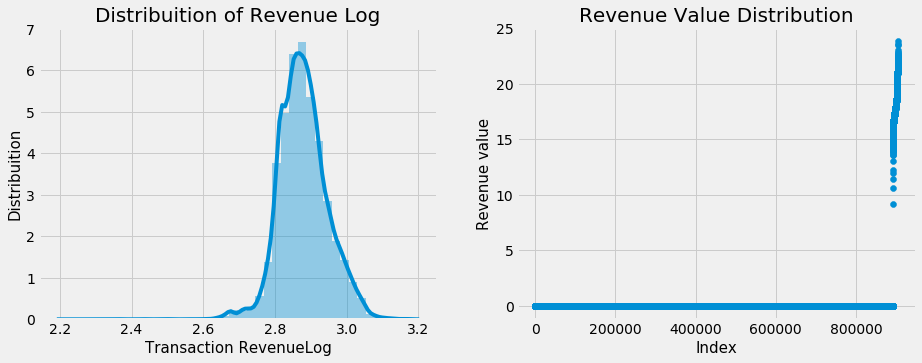

In [111]:
print("Transaction Revenue Min Value: ", 
      train_rev["totals.transactionRevenue"].min()) # printing the min value
print("Transaction Revenue Mean Value: ", 
      train_rev["totals.transactionRevenue"].mean()) # mean value
print("Transaction Revenue Median Value: ", 
      train_rev["totals.transactionRevenue"].median()) # median value
print("Transaction Revenue Max Value: ", 
      train_rev["totals.transactionRevenue"].max()) # the max value

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
# seting the distribuition of our data and normalizing using np.log on values highest than 0 and + 
# also, we will set the number of bins and if we want or not kde on our histogram
ax = sns.distplot(np.log(train_rev["totals.transactionRevenue"] + 0.01), bins=40, kde=True)
ax.set_xlabel('Transaction RevenueLog', fontsize=15) #seting the xlabel and size of font
ax.set_ylabel('Distribuition', fontsize=15) #seting the ylabel and size of font
ax.set_title("Distribuition of Revenue Log", fontsize=20) #seting the title and size of font

# setting the second plot of our grid of graphs
plt.subplot(1,2,2)
plt.scatter(range(train.shape[0]), np.sort(train['totals.transactionRevenue'].values))
plt.xlabel('Index', fontsize=15) # xlabel and size of words
plt.ylabel('Revenue value', fontsize=15) # ylabel and size of words
plt.title("Revenue Value Distribution", fontsize=20) # Setting Title and fontsize

plt.show()

We used log1p to normalize the revenues because it has high skewness. The second graph shows that the 80/20 situation trully exsits. And in the following analysis, we will try to find the reason.

## Feature Selection

Let's look deep into the columns to find their relationship with each other and revenue. So that we can dicide which feature can get into our models

In [112]:
def RevenueAndAllComparePlt(a, b, ColumnName, ColumnNumbers = np.nan):
    if ColumnNumbers == ColumnNumbers:
        values = b[ColumnName].value_counts()[:ColumnNumbers]
        smalla = a.loc[a[ColumnName].isin(values.index.values), ColumnName]
        df = pd.DataFrame({'All':smalla.value_counts() / len(a), 'Revenue':values / len(b)})
    else:
        df = pd.DataFrame({'All':a[ColumnName].value_counts()/len(a), 'Revenue': b[ColumnName].value_counts()/len(b)})
    n = len(df)
    X = df.index.values
    Y1 = df['All']
    Y2 = df['Revenue']
    plt.figure(figsize=(20,5))
    plt.yticks([])
    plt.bar(X, +Y1,facecolor='#9999ff', edgecolor='white', label='all data')
    plt.bar(X, -Y2,facecolor='#ff9999', edgecolor='white', label = 'Revenue > 0')
    plt.legend(loc='upper left')
    for x, y in zip(X, Y1):
    # ha: horizontal alignment
    # va: vertical alignment
        plt.text(x, y, '%.2f' % y, ha='center', va='bottom')
    for x, y in zip(X, Y2):
        plt.text(x, -y, '%.2f' % y, ha='center', va='top')
    plt.show()

### Channels

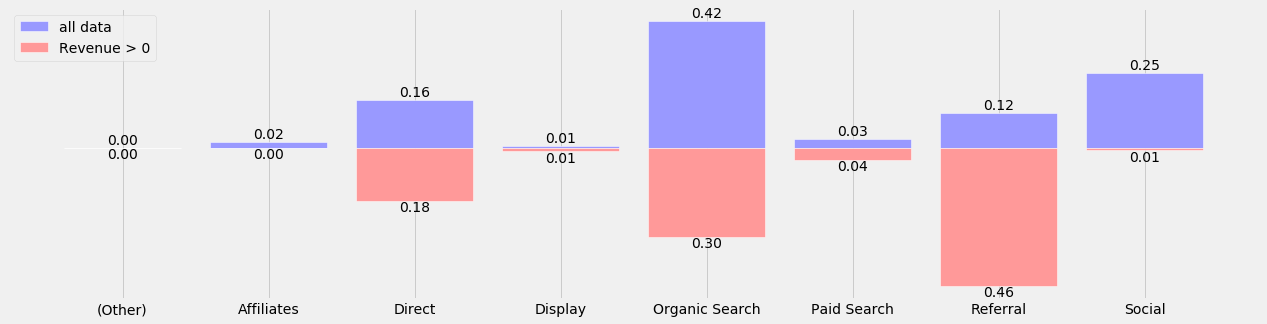

In [113]:
RevenueAndAllComparePlt(train, train_rev, 'channelGrouping')

We can see that Top 5 channels bring 98% visits:
TOP 1 => Organic Search - 42%
TOP 2 => Social.        - 25%
TOP 3 => Direct         - 16%
TOP 4 => Referral       - 12%
TOP 5 => Paid Search    - 3%

And Top 4 channel bring 98% revenues:

TOP 1 => Referral       - 46%
TOP 2 => Organic Search - 30%
TOP 3 => Direct         - 18%
TOP 4 => Paid Search    - 4%

Referral is the most efficient channel becasue its has the highest conversion rete. Another insight is that also paid search does not attract high visits, but its conversion rate is high.

### Operating System - OS

unique operatingSystem count: 20


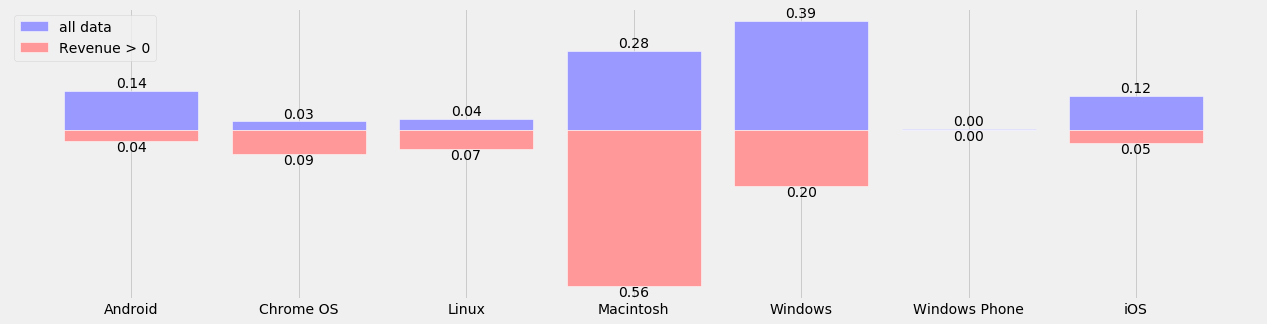

In [114]:
print('unique operatingSystem count:', train['device.operatingSystem'].nunique())
RevenueAndAllComparePlt(train, train_rev, 'device.operatingSystem', 10)

### Device Browser

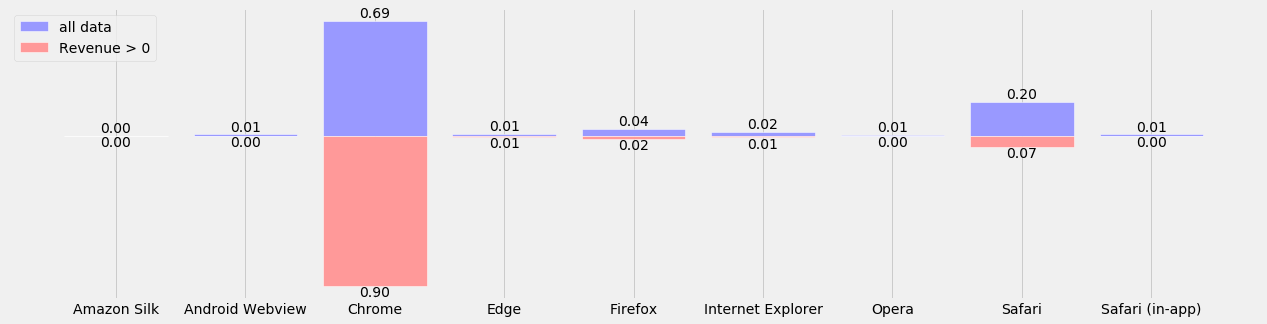

In [115]:
RevenueAndAllComparePlt(train, train_rev, 'device.browser', 10)

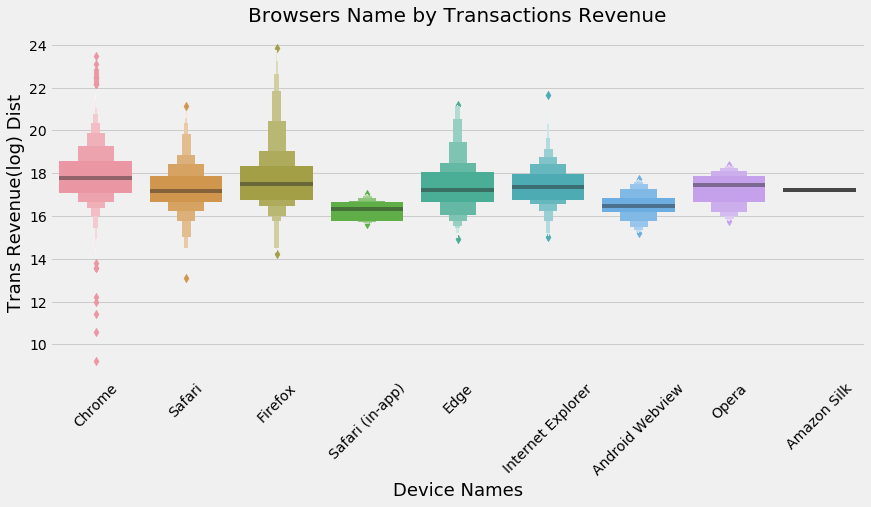

In [116]:
plt.figure(figsize=(13,6)) #figure size

#It's another way to plot our data. using a variable that contains the plot parameters
g1 = sns.boxenplot(x='device.browser', y='totals.transactionRevenue', 
                   data = train_rev[train_rev['device.browser'].isin(train_rev['device.browser'].value_counts()[:10].index.values)])
g1.set_title('Browsers Name by Transactions Revenue', fontsize=20) # title and fontsize
g1.set_xticklabels(g1.get_xticklabels(),rotation=45) # It's the way to rotate the xticks when we use variable to our graphs
g1.set_xlabel('Device Names', fontsize=18) # Xlabel
g1.set_ylabel('Trans Revenue(log) Dist', fontsize=18) #Ylabel

plt.show()

The graph give us interesting insights. We can see that Chrome brings most revenues,which takes 0.69,  but firefox brings the highest single revenue.

The TOP 3 browser represents 99% of total revenues. Respectivelly:

TOP 1 => Chrome - 90%
TOP 2 => Safari - 7%
TOP 3 => Firefox - 2%

The TOP 5 browser sysstem represents 99% of total revenues. Respectivelly:

TOP 1 => Macintosh - 56%
TOP 2 => Windows   - 20%
TOP 3 => Chrome OS - 9%
TOP 4 => Linux     - 7%
TOP 5 => iOS       - 5%

I have some new insighs: 
Firstly Apple users(Mobile or Mac) have more purchase intention, different marketing strategies can aim at this segment. 
Secondly, the Windows users have many visits, but don't purchase as that much, so we can make specific plans to transform that visit into purchase.
The following graph is more direct:

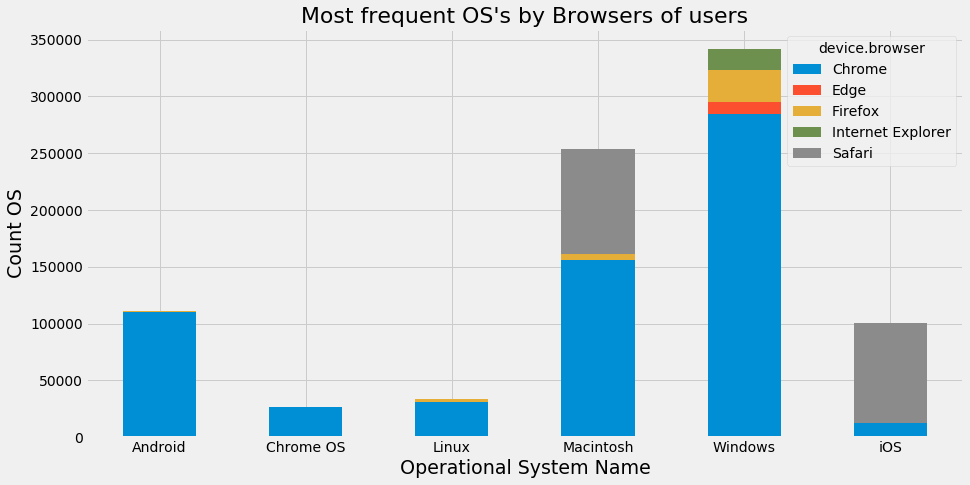

In [117]:
crosstab_eda = pd.crosstab(index=train[train['device.operatingSystem']\
                                          .isin(train['device.operatingSystem']\
                                                .value_counts()[:6].index.values)]['device.operatingSystem'], 
                           
                           # only top 5 browsers
                           columns=train[train['device.browser'].isin(train['device.browser']\
                                                                            .value_counts()[:5].index.values)]['device.browser'])
# Ploting the crosstab that we did above
crosstab_eda.plot(kind="bar",    # select the bar to plot the count of categoricals
                 figsize=(14,7), # adjusting the size of graphs
                 stacked=True)   # code to unstack 
plt.title("Most frequent OS's by Browsers of users", fontsize=22) # adjusting title and fontsize
plt.xlabel("Operational System Name", fontsize=19) # adjusting x label and fontsize
plt.ylabel("Count OS", fontsize=19) # adjusting y label and fontsize
plt.xticks(rotation=0) # Adjust the xticks, rotating the labels

plt.show() # rendering

### Mobile or Not

False    664530
True     239123
Name: device.isMobile, dtype: int64


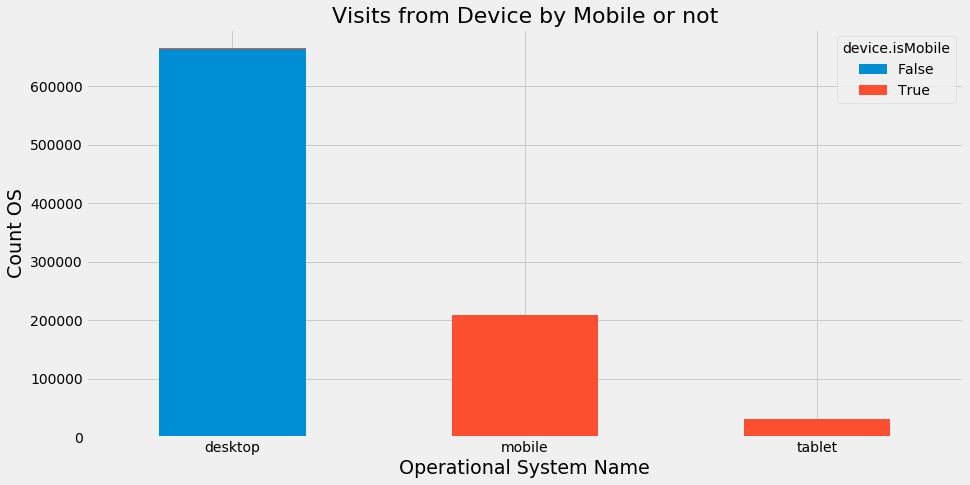

In [118]:
print(train['device.isMobile'].value_counts())
crosstab_device = pd.crosstab(train['device.deviceCategory'], train['device.isMobile'], margins=False)

crosstab_device.plot(kind="bar",    # select the bar to plot the count of categoricals
                 figsize=(14,7), # adjusting the size of graphs
                 stacked=True)   # code to unstack 
plt.title("Visits from Device by Mobile or not", fontsize=22) # adjusting title and fontsize
plt.xlabel("Operational System Name", fontsize=19) # adjusting x label and fontsize
plt.ylabel("Count OS", fontsize=19) # adjusting y label and fontsize
plt.xticks(rotation=0) # Adjust the xticks, rotating the labels

plt.show() # rendering

From the graph we can see that most of visits are from desktop, which aggrees to the findings defore.

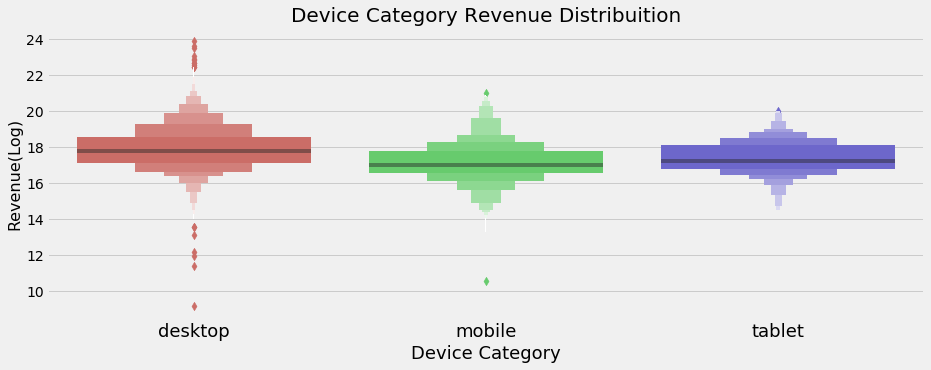

In [119]:
plt.figure(figsize=(14,5))
sns.boxenplot(x="device.deviceCategory", y = 'totals.transactionRevenue', 
              data=train_rev, palette="hls") # It's a module to count the category's
plt.title("Device Category Revenue Distribuition", fontsize=20) # seting the title size
plt.xlabel("Device Category", fontsize=18) # seting the x label size
plt.ylabel("Revenue(Log)", fontsize=16) # seting the y label size
plt.xticks(fontsize=18) # Adjust the xticks, rotating the labels

plt.subplots_adjust(hspace = 0.9, wspace = 0.5)

plt.show() #use plt.show to render the graph that we did above


And now we know that purchses are also mainly from desktop and the highest purchases are all made on desktop. This gives us the insights that perhaps people wouldn't like to make large amounts purchases on mobile device.

### Locations

unique geoNetwork.country count: 222


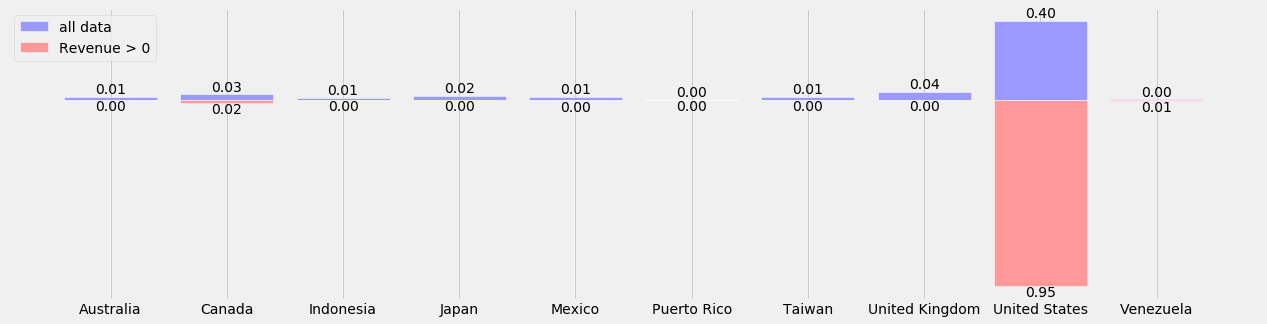

In [120]:
print('unique geoNetwork.country count:', train['geoNetwork.country'].nunique())
RevenueAndAllComparePlt(train, train_rev, 'geoNetwork.country', 10)

Another way to present the sales in different countries

In [121]:
import plotly
plotly.tools.set_credentials_file(username='mli60', api_key='JacPFN7YoUpfQ5SkLWkw')
from plotly.plotly import iplot

In [122]:
sumRevMaps = train_rev.groupby("geoNetwork.country")["totals.transactionRevenue"].count().to_frame().reset_index()
sumRevMaps.columns = ["country", "count_sales"] # renaming columns
sumRevMaps = sumRevMaps.reset_index().drop('index', axis=1) #reseting index and drop index column

data = [ dict(
        type = 'choropleth',
        locations = sumRevMaps['country'],
        locationmode = 'country names',
        z = sumRevMaps['count_sales'],
        text = sumRevMaps['country'],
        autocolorscale = False,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            tickprefix = '',
            title = 'Count of Sales'),
      ) ]

layout = dict(
    title = 'Total Sales by Country',
    geo = dict(
        showframe = False,
        showcoastlines = True,
        projection = dict(
            type = 'Mercator'
        )
    )
)

figure = dict( data=data, layout=layout )

iplot(figure, validate=False, filename='map-countrys-total')

unique geoNetwork.region count: 376


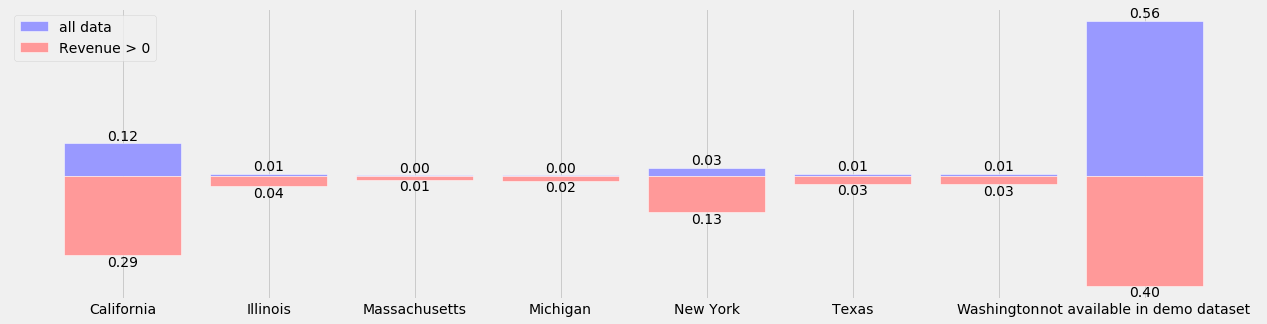

In [123]:
print('unique geoNetwork.region count:', train['geoNetwork.region'].nunique())
RevenueAndAllComparePlt(train, train_rev, 'geoNetwork.region', 8)

unique geoNetwork.city count: 649


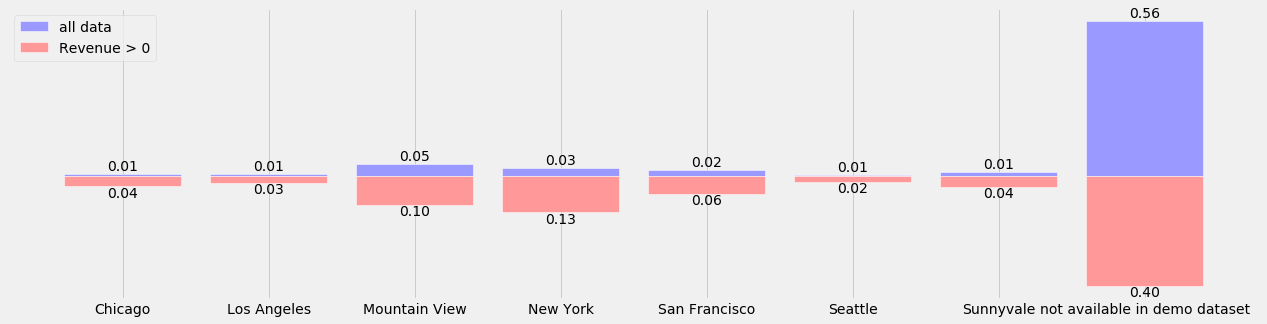

In [124]:
print('unique geoNetwork.city count:', train['geoNetwork.city'].nunique())
RevenueAndAllComparePlt(train, train_rev, 'geoNetwork.city', 8)

We know that visits are from many different countries, but the revenue are bacically form two countries: United States (95%) and Canada (2%).
And in the United States, the revenue are from Califonia and New York. So when building the models, maybe we can use regions as a feature to describe location.

### Seasonality

First I will display the revenue by date.

In [125]:
# I saw and take a lot of inspiration to this interactive plots in kernel: 
# https://www.kaggle.com/jsaguiar/complete-exploratory-analysis-all-columns
#seting some static color options
color_op = ['#5527A0', '#BB93D7', '#834CF7', '#6C941E', '#93EAEA', '#7425FF', '#F2098A', '#7E87AC', 
            '#EBE36F', '#7FD394', '#49C35D', '#3058EE', '#44FDCF', '#A38F85', '#C4CEE0', '#B63A05', 
            '#4856BF', '#F0DB1B', '#9FDBD9', '#B123AC']

# Visits by time train

# couting all entries by date to get number of visits by each date
dates_temp = train['date'].value_counts().to_frame().reset_index().sort_values('index') 
# renaming the columns to apropriate names
dates_temp = dates_temp.rename(columns = {"date" : "visits"}).rename(columns = {"index" : "date"})

# creating the first trace with the necessary parameters
trace = go.Scatter(x=dates_temp.date.astype(str), y=dates_temp.visits,
                    opacity = 0.8, line = dict(color = color_op[3]), name= 'Visits by day')

# Below we will get the total values by Transaction Revenue Log by date
dates_temp_sum = train.groupby('date')['totals.transactionRevenue'].sum().to_frame().reset_index()

# using the new dates_temp_sum we will create the second trace
trace1 = go.Scatter(x=dates_temp_sum.date.astype(str), line = dict(color = color_op[1]), name="RevenueLog by day",
                        y=dates_temp_sum['totals.transactionRevenue'], opacity = 0.8)

# Getting the total values by Transactions by each date
dates_temp_count = train_rev.groupby('date')['totals.transactionRevenue'].count().to_frame().reset_index()

# using the new dates_temp_count we will create the third trace
trace2 = go.Scatter(x=dates_temp_count.date.astype(str), line = dict(color = color_op[5]), name="Sellings by day",
                        y=dates_temp_count['totals.transactionRevenue'], opacity = 0.8)

#creating the layout the will allow us to give an title and 
# give us some interesting options to handle with the outputs of graphs
layout = dict(
    title= "Informations by Date",
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label='1m', step='month', stepmode='backward'),
                dict(count=3, label='3m', step='month', stepmode='backward'),
                dict(count=6, label='6m', step='month', stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(visible = True),
        type='date'
    )
)

# creating figure with the both traces and layout
fig = dict(data= [trace, trace1, trace2], layout=layout)

#rendering the graphs
iplot(fig) #it's an equivalent to plt.show()

### the visithour distribution by weekday and revenue by visithour

In [126]:
date_sales = ['_visitHour', '_weekday']  

cm = sns.light_palette("red", as_cmap=True)
pd.crosstab(train[date_sales[0]], train[date_sales[1]], 
            values=train_rev['totals.transactionRevenue'], aggfunc=[np.sum]).style.background_gradient(cmap = cm)

# tab.columns.levels[1] = ["Sun", "Mon", "Thu", "wed", "Thi","Fri","Sat"]

From this graph we can see the highest revenues appear around 16 hours.

## From all ablove

## Aggregate

In [14]:
train['totals.transactionRevenue'].describe()

count    9.036530e+05
mean     1.704273e+06
std      5.277866e+07
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.312950e+10
Name: totals.transactionRevenue, dtype: float64

In [127]:
_='''
'''
train['_meanHitsPerDay'] = train.groupby(['_day'])['totals.hits'].transform('mean')
train['_meanHitsPerWeekday'] = train.groupby(['_weekday'])['totals.hits'].transform('mean')
train['_meanHitsPerMonth'] = train.groupby(['_month'])['totals.hits'].transform('mean')
train['_sumHitsPerDay'] = train.groupby(['_day'])['totals.hits'].transform('sum')
train['_sumHitsPerWeekday'] = train.groupby(['_weekday'])['totals.hits'].transform('sum')
train['_sumHitsPerMonth'] = train.groupby(['_month'])['totals.hits'].transform('sum')

for feature in ['totals.hits', 'totals.pageviews']:
    info = train_try.groupby('fullVisitorId')[feature].mean()
    train['_usermean_' + feature] = train.fullVisitorId.map(info)
    
for feature in ['visitNumber']:
    info = train.groupby('fullVisitorId')[feature].max()
    train['_usermax_' + feature] = train.fullVisitorId.map(info)

del info

In [128]:
train.drop(['visitId','visitStartTime'],axis=1,inplace=True)
for i, t in train.loc[:, train.columns != 'fullVisitorId'].dtypes.iteritems():
    if t == object:
        train[i].fillna('unknown', inplace=True)
        train[i] = pd.factorize(train[i])[0]

In [129]:
train_id = train['fullVisitorId']

In [130]:
_='''
'''
test['_meanHitsPerDay'] = test.groupby(['_day'])['totals.hits'].transform('mean')
test['_meanHitsPerWeekday'] = test.groupby(['_weekday'])['totals.hits'].transform('mean')
test['_meanHitsPerMonth'] = test.groupby(['_month'])['totals.hits'].transform('mean')
test['_sumHitsPerDay'] = test.groupby(['_day'])['totals.hits'].transform('sum')
test['_sumHitsPerWeekday'] = test.groupby(['_weekday'])['totals.hits'].transform('sum')
test['_sumHitsPerMonth'] = test.groupby(['_month'])['totals.hits'].transform('sum')

for feature in ['totals.hits', 'totals.pageviews']:
    info = test_try.groupby('fullVisitorId')[feature].mean()
    test['_usermean_' + feature] = test_try.fullVisitorId.map(info)
    
for feature in ['visitNumber']:
    info = test_try.groupby('fullVisitorId')[feature].max()
    test['_usermax_' + feature] = test.fullVisitorId.map(info)

del info

In [131]:
test.drop(['visitId','visitStartTime'],axis=1,inplace=True)
for i, t in test.loc[:, test.columns != 'fullVisitorId'].dtypes.iteritems():
    if t == object:
        test[i].fillna('unknown', inplace=True)
        test[i] = pd.factorize(test[i])[0]

In [132]:
test_id= test['fullVisitorId']

In [134]:
Y_train_reg = train.pop('totals.transactionRevenue')
Y_train_cls = (Y_train_reg.fillna(0) > 0).astype(np.uint8)
X_train = train.drop(['date','fullVisitorId'], axis=1)
X_test  = test.drop(['date','fullVisitorId'], axis=1)
print(X_train.shape, X_test.shape)

(903653, 44) (804684, 44)


In [135]:
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

In [24]:
#test_try['totals.hits'] = test_try['totals.hits'].astype(float)


In [138]:
params={'learning_rate': 0.01,
        'objective':'regression',
        'metric':'rmse',
        'num_leaves': 31,
        'verbose': 1,
        'random_state':42,
        'bagging_fraction': 0.6,
        'feature_fraction': 0.6
       }

folds = GroupKFold(n_splits=5)

oof_preds = np.zeros(X_train.shape[0])
sub_preds = np.zeros(X_test.shape[0])
for fold_, (trn_, val_) in enumerate(folds.split(X_train, Y_train_reg, groups=train_id)):
    trn_x, trn_y = X_train.iloc[trn_], Y_train_reg.iloc[trn_]
    val_x, val_y = X_train.iloc[val_], Y_train_reg.iloc[val_]
    
    reg = lgb.LGBMRegressor(**params, n_estimators=3000)
    reg.fit(trn_x, trn_y, eval_set=[(val_x, val_y)], early_stopping_rounds=50, verbose=500)
    
    oof_preds[val_] = reg.predict(val_x, num_iteration=reg.best_iteration_)
    sub_preds += reg.predict(X_test, num_iteration=reg.best_iteration_) / folds.n_splits

pred = sub_preds

Training until validation scores don't improve for 50 rounds.
[500]	valid_0's rmse: 1.62113
[1000]	valid_0's rmse: 1.60642
[1500]	valid_0's rmse: 1.6002
[2000]	valid_0's rmse: 1.59793
[2500]	valid_0's rmse: 1.59674
Early stopping, best iteration is:
[2475]	valid_0's rmse: 1.59667
Training until validation scores don't improve for 50 rounds.
[500]	valid_0's rmse: 1.64526
[1000]	valid_0's rmse: 1.63344
[1500]	valid_0's rmse: 1.62873
Early stopping, best iteration is:
[1774]	valid_0's rmse: 1.62753
Training until validation scores don't improve for 50 rounds.
[500]	valid_0's rmse: 1.6075
[1000]	valid_0's rmse: 1.59011
[1500]	valid_0's rmse: 1.58255
[2000]	valid_0's rmse: 1.57867
Early stopping, best iteration is:
[2346]	valid_0's rmse: 1.57742
Training until validation scores don't improve for 50 rounds.
[500]	valid_0's rmse: 1.65568
[1000]	valid_0's rmse: 1.64107
[1500]	valid_0's rmse: 1.6366
Early stopping, best iteration is:
[1915]	valid_0's rmse: 1.63504
Training until validation scor

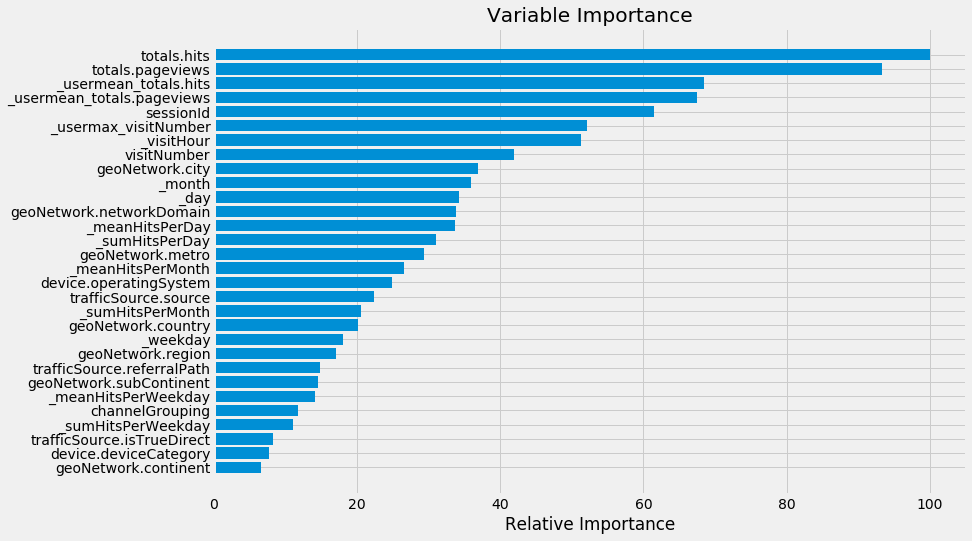

In [139]:
feature_importance = reg.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
sorted_idx = sorted_idx[len(feature_importance) - 30:]
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(12,8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [143]:
submission = pd.DataFrame({'fullVisitorId':test_id, 'PredictedLogRevenue':pred})

submission["PredictedLogRevenue"] = np.expm1(submission["PredictedLogRevenue"])
submission["PredictedLogRevenue"] = submission["PredictedLogRevenue"].apply(lambda x : 0.0 if x < 0 else x)
submission["PredictedLogRevenue"] = submission["PredictedLogRevenue"].fillna(0.0)

submission_sum = submission[['fullVisitorId', 'PredictedLogRevenue']].groupby('fullVisitorId').sum().reset_index()
submission_sum["PredictedLogRevenue"] = np.log1p(submission_sum["PredictedLogRevenue"])
submission_sum.to_csv("submission_1.csv", index=False)
submission_sum.head(20)

,fullVisitorId,PredictedLogRevenue
0,0000000259678714014,0.000000
1,0000049363351866189,0.004351
2,0000053049821714864,0.000000
3,0000059488412965267,0.191260
4,0000085840370633780,0.000000
5,0000091131414287111,0.000000
6,0000117255350596610,1.284589
7,0000118334805178127,0.000000
8,0000130646294093000,0.000000
9,0000150005271820273,0.000000


In [142]:
submission_sum['PredictedLogRevenue'].describe()

count    617242.000000
mean          0.047595
std           0.237498
min           0.000000
25%           0.000000
50%           0.000000
75%           0.001669
max           6.334250
Name: PredictedLogRevenue, dtype: float64

# To be continued...